In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import autokeras as ak
import keras_tuner
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint


2024-08-19 21:23:47.529576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 21:23:47.544659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 21:23:47.549280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 21:23:47.561131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 21:23:48.166305: W tensorflow/compiler/tf2

In [6]:
# @title Загрузка готового датасета с углами

# Версия дата сета
v = 3 #(Версия 1 с углами относительно торса и относительно друг друга. Версия 2 с углами относительно вертикали это первые значения. Вторые и последующие значения это изменения угла относительно предыдущего кадра. Версия 3 все значения с углами относительно вертикали)

# Кол-во кадров, взятых подряд для исследования
n = 5

# Кол-во примеров в обучающем датасете
s = 300000
folder = 'Data/result/ok_data/dataset_finish/angles_vertical_MMA3'
# Загрузка готового датасета
x_train = np.load(f'{folder}/angles_train_{n}_{s}_v{v}.npy')
y_train = np.load(f'{folder}/labels_angles_train_{n}_{s}v{v}.npy')
x_val = np.load(f'{folder}/angles_val_{n}_{s}v{v}.npy')
y_val = np.load(f'{folder}/labels_angles_val_{n}_{s}v{v}.npy')
x_test = np.load(f'{folder}/angles_test_{n}_{s}v{v}.npy')
y_test = np.load(f'{folder}/labels_angles_test_{n}_{s}v{v}.npy')


# Проверка размерности датасета для обуччния
print('Размерность датасета для обучения')
print(x_train.shape)
print(y_train.shape)

# Проверка размерности тестового датасета
print('Размерность датасета для валидации')
print(x_val.shape)
print(y_val.shape)

# Проверка размерности тестового датасета
print('Размерность тестового датасета')
print(x_test.shape)
print(y_test.shape)


Размерность датасета для обучения
(100000, 5, 8, 2)
(100000,)
Размерность датасета для валидации
(10000, 5, 8, 2)
(10000,)
Размерность тестового датасета
(10000, 5, 8, 2)
(10000,)


Epoch 1/200


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6070 - loss: 0.6724 - val_accuracy: 0.7813 - val_loss: 0.4464
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7590 - loss: 0.4992 - val_accuracy: 0.7992 - val_loss: 0.4355
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7839 - loss: 0.4545 - val_accuracy: 0.8137 - val_loss: 0.4284
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8072 - loss: 0.4213 - val_accuracy: 0.8243 - val_loss: 0.4139
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8179 - loss: 0.4010 - val_accuracy: 0.8303 - val_loss: 0.3975
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8351 - loss: 0.3767 - val_accuracy: 0.8416 - val_loss: 0.3787
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.3634 - val_accuracy: 0.8468 - val_loss: 0.3652
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8523 - loss: 0.3472 - val_accuracy: 0.8566 - val_loss: 0.

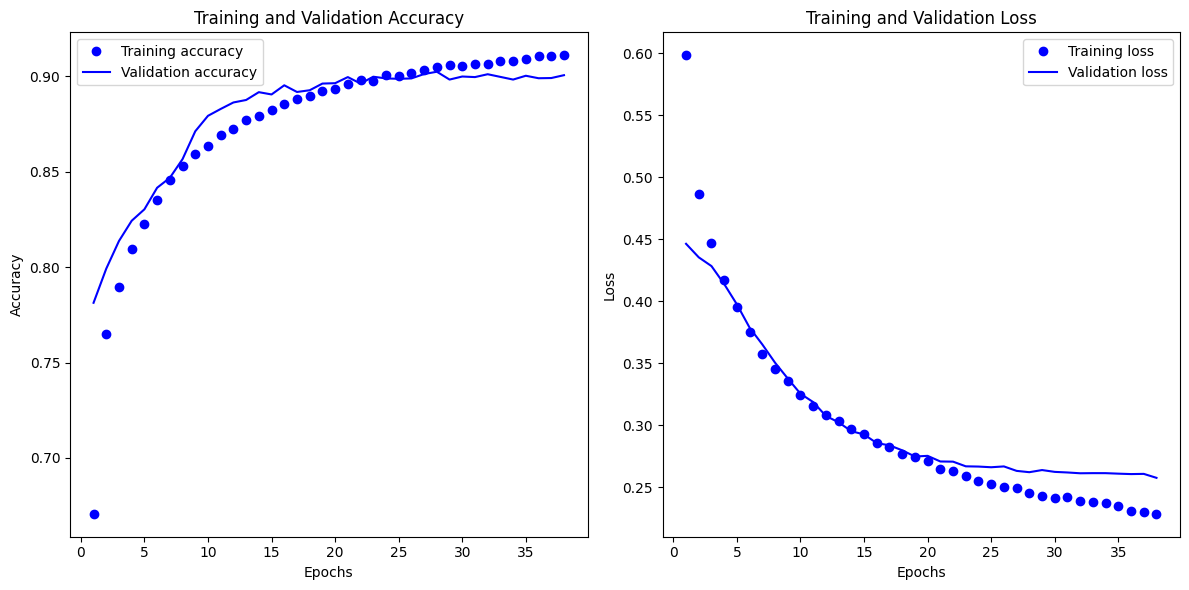

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, ReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Настройка callbacks для ранней остановки и сохранения модели
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Мониторинг точности на валидационном наборе
    patience=10,  # Количество эпох без улучшения, после которых обучение будет остановлено
    mode='max',  # Оптимизация на максимальную точность
    restore_best_weights=True  # Восстановление лучших весов модели
)

checkpoint = ModelCheckpoint(
    'best_model.keras',  # Имя файла для сохранения модели
    monitor='val_accuracy',  # Мониторинг точности на валидационном наборе
    save_best_only=True,  # Сохранение только лучших весов
    mode='max'  # Оптимизация на максимальную точность
)

# Определение входного слоя
input_layer = Input(shape=(5, 8, 2), name="input_layer")

# Развертывание данных в одномерный вектор
x = Flatten(name="flatten")(input_layer)

# Полносвязный слой с 256 нейронами
x = Dense(64, name="dense1")(x)


# Функция активации ReLU
x = ReLU(name="re_lu")(x)

# Слой Dropout для регуляризации
x = Dropout(0.4, name="dropout")(x)

# Еще один слой Dropout (если необходимо)
x = Dropout(0.4, name="dropout_1")(x)

# Полносвязный выходной слой с 1 нейроном (для бинарной классификации)
output_layer = Dense(1, activation="sigmoid", name="dense_1")(x)

# Создание модели
model = Model(inputs=input_layer, outputs=output_layer, name="custom_model")

# Компиляция модели
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["accuracy"])

# Сбор данных о ходе обучения
history = model.fit(
    x_train, y_train,
    epochs=200,
    validation_data=(x_val, y_val),
    batch_size=2048,
    callbacks=[early_stopping, checkpoint]
)

# Получение данных из истории обучения
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

# Построение графиков точности и потерь
plt.figure(figsize=(12, 6))

# График точности на обучающем и валидационном наборах
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 5, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 5, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,993 (82.00 KB)

 Trainable params: 20,993 (82.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Проверка точности модели
loss, acc = model.evaluate(angles_val, labels_angles_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

625/625 - 1s - 2ms/step - accuracy: 0.9047 - loss: 0.2373
Restored model, accuracy: 90.47%
